In [1]:
import fiona
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import healpy as hp
import xarray as xr

# CEH crop data

The UK Centre for Ecology and Hydrology Land Cover Plus crop maps (https://www.ceh.ac.uk/services/ceh-land-cover-plus-crops-2015) use remote sensing data from two satellites, Copernicus Sentinel-1 C-band SAR and Sentinel-2 optical imaging, to generate a catalog of land parcels classified by crop types.
Data can be accessed through a free academic licence from Digimap (https://digimap.edina.ac.uk/environment), going to 'Environment Data Download'.

To get the data select an area of interest on the map using the drawing tools and then select the desired dataset for the selected area. Land Cover Plus provides data for the 2016-2020 year range.
After adding the datasets to the basket and checking out, a confirmation email is sent to get access to the files in `.gdb` format.
The naming of the files depends on the ID of the data query, hence we rename them here for clarity.

In this notebook we plot the positions and crop types within the historic county of Yorkshire.
To obtain the Yorkshire county boundaries we use Boundary-Lane data from the Ordnance Survey Data Hub https://osdatahub.os.uk/downloads/open/BoundaryLine, which can be accessed for free by selecting the GeoPackage data format, and extracting the `bdline_gb.gpkg` file.

Then, a CSV file containing positions, area, and crop types is generated and saved for use in the package.

In [2]:
# Resolution in meters
resolution = 1000

# Year 2016 - 
years = np.arange(2016,2022)

border_file = '../../data/land/bdline_gb.gpkg' 
crop_files = [f'../../data/land/CEH/UK_CEH_Crops_{year}.gdb' for year in years]

In [3]:
fiona.listlayers(border_file)

['boundary_line_ceremonial_counties',
 'boundary_line_historic_counties',
 'community_ward',
 'country_region',
 'county',
 'county_electoral_division',
 'district_borough_unitary',
 'district_borough_unitary_ward',
 'english_region',
 'greater_london_const',
 'high_water',
 'historic_european_region',
 'parish',
 'polling_districts_england',
 'scotland_and_wales_const',
 'scotland_and_wales_region',
 'unitary_electoral_division',
 'westminster_const']

In [4]:
# Yorkshire = 66
counties = gpd.read_file(border_file, layer='boundary_line_historic_counties')
polygon = counties['geometry'].iloc[66]
counties

,Name,Area_Description,geometry
0,Berkshire,Historic County,"MULTIPOLYGON (((422004.502 199086.601, 422030...."
1,Buckinghamshire,Historic County,"MULTIPOLYGON (((460619.899 235588.003, 460625...."
2,Hertfordshire,Historic County,"MULTIPOLYGON (((499772.602 215220.503, 499795...."
3,Herefordshire,Historic County,"MULTIPOLYGON (((335069.501 272770.499, 335082...."
4,Oxfordshire,Historic County,"MULTIPOLYGON (((424473.304 224921.896, 424502...."
...,...,...,...
90,Warwickshire,Historic County,"MULTIPOLYGON (((456472.501 274014.303, 456299...."
91,Dorset,Historic County,"MULTIPOLYGON (((333203.198 91375.703, 333185.9..."
92,Devon,Historic County,"MULTIPOLYGON (((333223.945 91353.145, 333218.0..."
93,Banffshire,Historic County,"MULTIPOLYGON (((349516.703 868874.397, 349519...."


In [5]:
xmin, ymin, xmax, ymax = polygon.bounds
print(xmin, ymin, xmax, ymax)
size = np.ceil([(xmax - xmin)/resolution, (ymax - ymin)/resolution]).astype(int)
print(size)

357386.0036 378555.099 542313.704 529856.1995
[185 152]


In [6]:
# Read and concatenate crop polygons. Add year to each entry
crops = [gpd.read_file(crop_files[iyear], mask = polygon).drop(columns = ['poly_id', 'parent', 'gid']) for iyear in range(len(years))]

for year, crop_year in zip(years, crops):
    crop_year["year"] = year
    
crops = pd.concat(crops)

# Create crop type dictionary
crop_codes = np.unique(crops['crop_code'])
code_dict = dict(zip(crop_codes, np.arange(len(crop_codes))))
print(code_dict)

# Add area, change geometry to centroid points
crops["area"] = crops.area
crops["geometry"] = crops.centroid

crops

{'be': 0, 'fb': 1, 'gr': 2, 'ma': 3, 'or': 4, 'ot': 5, 'pe': 6, 'po': 7, 'sb': 8, 'sl': 9, 'so': 10, 'sw': 11, 'wb': 12, 'wo': 13, 'ww': 14}


,crop_code,crop_name,geometry,year,area
0,ww,Winter wheat (includes winter oats),POINT (442859.522 508448.684),2016,74182.096573
1,ww,Winter wheat (includes winter oats),POINT (456453.823 390562.285),2016,102396.034547
2,ww,Winter wheat (includes winter oats),POINT (453655.976 436410.488),2016,83870.444163
3,ww,Winter wheat (includes winter oats),POINT (423851.198 408246.850),2016,24454.634953
4,ww,Winter wheat (includes winter oats),POINT (432151.516 502714.686),2016,34701.408029
...,...,...,...,...,...
125035,so,Spring oats,POINT (482782.927 485181.763),2021,81178.421524
125036,so,Spring oats,POINT (450190.393 437509.690),2021,68678.318668
125037,so,Spring oats,POINT (488744.682 440761.129),2021,62240.175824
125038,so,Spring oats,POINT (491061.811 478375.351),2021,35739.688410


In [7]:
# Get the crop type id, posx, posy and year to build the histogram
itype = np.zeros(len(crops), dtype=int)

for it, t in enumerate(crops["crop_code"]):
        itype[it] = code_dict[t]

posx = crops['geometry'].x.to_numpy()
posy = crops['geometry'].y.to_numpy()

binsx = np.linspace(xmin, xmax, size[0]+1)
binsy = np.linspace(ymin, ymax, size[1]+1)

crop_year = crops['year'].to_numpy()


In [8]:
# Get the pixelised crop data from a multidimensional histogram
areas, bins = np.histogramdd([crop_year, itype, posx, posy],
                             bins = (0.5+(np.arange(2015, 2022)), 0.5+np.arange(-1,15), binsx, binsy),
                             weights=crops['area'])

In [9]:
xcoords = 0.5 * (binsx[1:] + binsx[:-1])
ycoords = 0.5 * (binsy[1:] + binsy[:-1])

# data = xr.DataArray(areas, dims=("Year", "Type", "x", "y"), coords={"Year":years, "Type":crop_codes, "x":xcoords, "y":ycoords})
data = xr.Dataset(
    data_vars = dict(
        area=(["Year", "Type", "x", "y"], areas)
    ),
    coords = dict(
        x=("x", xcoords),
        y=("y", ycoords),
        Year=("Year", years),
        Type=("Type", crop_codes),        
    )
)
data = data.where(data != 0, other=np.nan)
data

<xarray.Dataset>
Dimensions:  (Year: 6, Type: 15, x: 185, y: 152)
Coordinates:
  * x        (x) float64 3.579e+05 3.589e+05 3.599e+05 ... 5.408e+05 5.418e+05
  * y        (y) float64 3.791e+05 3.8e+05 3.81e+05 ... 5.284e+05 5.294e+05
  * Year     (Year) int64 2016 2017 2018 2019 2020 2021
  * Type     (Type) object 'be' 'fb' 'gr' 'ma' 'or' ... 'so' 'sw' 'wb' 'wo' 'ww'
Data variables:
    area     (Year, Type, x, y) float64 nan nan nan nan nan ... nan nan nan nan

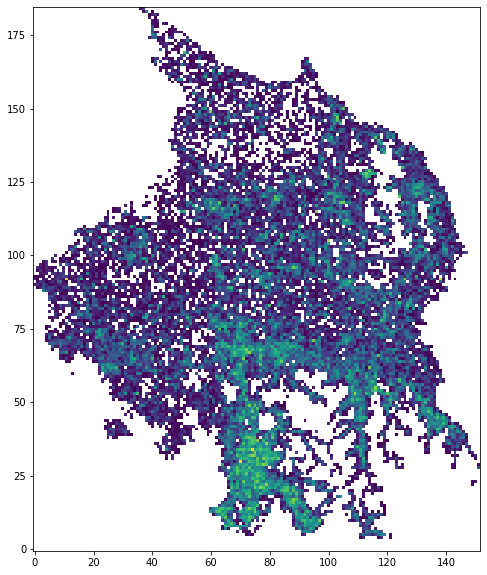

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(data.area.sel(Year=2020, Type='gr'), interpolation='none', origin='lower')

In [11]:
encoding = {"area":{"dtype":"float32", "zlib": True, "complevel": 5}}
data.to_netcdf(f"../../agrifoodpy/land/data/CEH/CEH_{resolution}.nc", encoding=encoding)